In [ ]:
import requests
import pandas as pd
import json
import os
import gc
from tqdm import tqdm
from time import sleep

# --- CONFIG ---
TOKEN = os.getenv("GITHUB_TOKEN")
HEADERS = {'Authorization': f'token {TOKEN}', 'Accept': 'application/vnd.github.v3+json'}
INPUT_FILE = "repos-min-1000stars.json"
OUTPUT_FILE = "github_repos_full_1000.csv"

BATCH_SIZE = 1000  # écriture tous les N dépôts
RATE_LIMIT_SLEEP = 2  # secondes entre requêtes pour ne pas se faire bloquer
LIMIT = 100

# --- LECTURE DU JSON PAR FLUX (pour éviter de charger 1.6 Go d’un coup) ---
import ijson
def json_stream(file_path, limit=None):
    with open(file_path, "r", encoding="utf-8") as f:
        for i, repo in enumerate(ijson.items(f, "item")):
            if limit and i >= limit:
                break
            yield repo

# --- REQUÊTE API ---
def get_github_json(url):
    try:
        r = requests.get(url, headers=HEADERS)
        if r.status_code == 200:
            return r.json()
        elif r.status_code == 403:  # Rate limit
            print("⏳ Rate limit atteint, pause 60s...")
            sleep(60)
            return get_github_json(url)
    except Exception as e:
        print(f"⚠️ Erreur sur {url}: {e}")
    return None

# --- PIPELINE ---
data = []

for i, repo in enumerate(tqdm(json_stream(INPUT_FILE, limit=LIMIT), total=LIMIT, desc="Fetching repos")):
    repo_data = {
        "full_name": repo.get("full_name"),
        "html_url": repo.get("html_url"),
        "description": repo.get("description"),
        "language": repo.get("language"),
        "stars": repo.get("stargazers_count"),
        "forks": repo.get("forks_count"),
        "open_issues": repo.get("open_issues_count"),
    }

    # Commits récents
    commits = get_github_json(repo["commits_url"].replace("{/sha}", "?per_page=5"))
    if commits:
        repo_data["recent_commit_messages"] = " ".join([c["commit"]["message"] for c in commits if "commit" in c])
    else:
        repo_data["recent_commit_messages"] = None

    # Pull requests
    pulls = get_github_json(repo["pulls_url"].replace("{/number}", "?state=all&per_page=5"))
    if pulls:
        repo_data["recent_pr_titles"] = " ".join([p["title"] for p in pulls if "title" in p])
    else:
        repo_data["recent_pr_titles"] = None

    # Issues
    issues = get_github_json(repo["issues_url"].replace("{/number}", "?state=open&per_page=5"))
    if issues:
        repo_data["recent_issue_titles"] = " ".join([i["title"] for i in issues if "title" in i])
    else:
        repo_data["recent_issue_titles"] = None

    # Contributors
    contributors = get_github_json(repo["contributors_url"] + "?per_page=5")
    if contributors:
        repo_data["top_contributors"] = ", ".join([c["login"] for c in contributors if "login" in c])
    else:
        repo_data["top_contributors"] = None

    data.append(repo_data)

    # --- Sauvegarde par lot ---
    if (i + 1) % BATCH_SIZE == 0:
        df = pd.DataFrame(data)
        write_header = not os.path.exists(OUTPUT_FILE)
        df.to_csv(OUTPUT_FILE, mode="a", index=False, header=write_header)
        print(f"💾 Écrit {len(data)} lignes -> {OUTPUT_FILE}")
        data.clear()
        gc.collect()
        sleep(RATE_LIMIT_SLEEP)  # petit délai pour GitHub

# --- Écrire le reste ---
if data:
    df = pd.DataFrame(data)
    write_header = not os.path.exists(OUTPUT_FILE)
    df.to_csv(OUTPUT_FILE, mode="a", index=False, header=write_header)
    print(f"💾 Dernier lot écrit ({len(data)} lignes)")
    data.clear()
    gc.collect()

print("\n✅ Extraction terminée.")


Fetching repos: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


💾 Dernier lot écrit (100 lignes)

✅ Extraction terminée.


In [5]:
df = pd.read_csv(OUTPUT_FILE)

print("\n=== Aperçu des premières lignes ===")
print(df.head())

print("\n=== Infos du DataFrame ===")
print(df.info())

print("\n=== Statistiques descriptives ===")
print(df.describe(include='all'))

print("\n=== Liste des colonnes ===")
print(df.columns.tolist())



=== Aperçu des premières lignes ===
                       full_name  \
0                  ahoward/testy   
1  mauricio/master_slave_adapter   
2          benaskins/simplegraph   
3                   headius/duby   
4          masuidrive/TiStoreKit   

                                           html_url  \
0                  https://github.com/ahoward/testy   
1  https://github.com/mauricio/master_slave_adapter   
2          https://github.com/benaskins/simplegraph   
3                   https://github.com/headius/duby   
4          https://github.com/masuidrive/TiStoreKit   

                                         description    language  stars  \
0  a BDD testing framework for ruby that's mad at...        Ruby    100   
1  An ActiveRecord database adapter that allows y...        Ruby    100   
2             Simple graphs using jQuery and Raphael  JavaScript    100   
3                      The Duby Programming Language        Ruby    100   
4  StoreKit(In App Purchase) module for 

In [13]:
df['text_for_classification'] = df['description'].fillna('') + " " + \
                                df['recent_commit_messages'].fillna('') + " " + \
                                df['recent_pr_titles'].fillna('') + " " + \
                                df['recent_issue_titles'].fillna('')


In [14]:
df.head()

,full_name,html_url,description,language,stars,forks,open_issues,recent_commit_messages,recent_pr_titles,recent_issue_titles,top_contributors,text_for_classification,category,label
0,ahoward/testy,https://github.com/ahoward/testy,a BDD testing framework for ruby that's mad at...,Ruby,100,5,1,"Deal with more ""it's"". Replace ""it's"" with its...",NaN,Support for Ruby 2?,"ahoward, agrimm",a BDD testing framework for ruby that's mad at...,other,2
1,mauricio/master_slave_adapter,https://github.com/mauricio/master_slave_adapter,An ActiveRecord database adapter that allows y...,Ruby,100,22,1,Apply fixes suggested by http://github.com/dee...,NaN,change the name,mauricio,An ActiveRecord database adapter that allows y...,web,5
2,benaskins/simplegraph,https://github.com/benaskins/simplegraph,Simple graphs using jQuery and Raphael,JavaScript,100,11,2,"Stylistic changes, remove disclaimer. Missing ...",NaN,Error in README Bug when using lowerBound bigg...,"benaskins, lachlanhardy, martinstannard, lachie",Simple graphs using jQuery and Raphael Stylist...,other,2
3,headius/duby,https://github.com/headius/duby,The Duby Programming Language,Ruby,100,10,4,Wipe out source and replace with a README poin...,NaN,Direct access to ARGV Compiling multiple .duby...,"headius, consiliens, nex3, Osseta, bobzoller",The Duby Programming Language Wipe out source ...,web,5
4,masuidrive/TiStoreKit,https://github.com/masuidrive/TiStoreKit,StoreKit(In App Purchase) module for Titanium ...,JavaScript,100,20,1,Updated docs add removedTransactions. it was f...,NaN,question,masuidrive,StoreKit(In App Purchase) module for Titanium ...,other,2


In [31]:
import topicwizard as tw
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

# Create topic pipeline
topic_pipeline = make_pipeline(
    CountVectorizer(),
    NMF(n_components=10),
)

# Then fit it on the given texts
topic_pipeline.fit(df['text_for_classification'])

/usr/local/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


,steps,"[('countvectorizer', ...), ('nmf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [32]:
import topicwizard

vectorizer = topic_pipeline.named_steps['countvectorizer']
nmf_model = topic_pipeline.named_steps['nmf']

# Extraire le vocabulaire et les composantes
vocab = vectorizer.get_feature_names_out()  # liste des mots
components = nmf_model.components_          # matrice topic x mot

# Now infer topic names
topic_names = topicwizard.infer_topic_names(vocab=vocab, components=components)

# Then you can visualize your results
topicwizard.visualize(pipeline=topic_pipeline, corpus=df['text_for_classification'], topic_names=topic_names)


Preprocessing


TypeError: Either corpus and model or topic_data has to be specified.

In [41]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text_for_classification'])

nmf_model = NMF(n_components=10, random_state=42)
nmf_model.fit(X)

doc_topic_matrix = nmf_model.transform(X)
dominant_topic = doc_topic_matrix.argmax(axis=1)

# Crée un DataFrame minimal
topic_data = pd.DataFrame({
    "document": df['text_for_classification'],
    "topic": dominant_topic
})

# Ici, TopicWizard ne pourra pas faire toutes les visualisations interactives,
# mais tu peux analyser les topics via doc_topic_matrix et topic_names


In [42]:
import pandas as pd
import numpy as np

n_top_words = 10
vocab = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [vocab[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")


Topic 0: for, jsni, add, fix, and, the, support, of, duby, gwt
Topic 1: the, ezbl, dan, to, is, by, for, inst, setf, off
Topic 2: to, lcdc, in, it, the, and, already, state, for, this
Topic 3: the, to, be, files, on, up, are, need, wiki, dated
Topic 4: readme, update, md, to, add, updated, java, and, text, for
Topic 5: jg, when, 2012, ge, review, in, issue, or, bugfix, 02
Topic 6: fix, from, to, request, pull, merge, in, add, fixed, master
Topic 7: patch, 2025, 07, autofic, security, to, js, 24, this, update
Topic 8: the, for, native, org, with, persona, retarget, firefoxos, should, connect
Topic 9: for, and, to, added, with, in, on, support, the, not


In [43]:
dominant_topic = np.argmax(doc_topic_matrix, axis=1)
df_topics = pd.DataFrame({
    "document": df['text_for_classification'],
    "dominant_topic": dominant_topic
})

# Voir quelques documents par topic
for topic_num in range(nmf_model.n_components):
    print(f"\n--- Topic {topic_num} ---")
    print(df_topics[df_topics['dominant_topic'] == topic_num]['document'].head(3))



--- Topic 0 ---
3     The Duby Programming Language Wipe out source ...
47    Allows to manage related records Merge pull re...
59    Engine Yard PHP Performance Tools Add APC/Zend...
Name: document, dtype: object

--- Topic 1 ---
9     An Emacs interface for Uzbl. Update use of `xw...
36    GoDCCP is an implementation of the Datagram Co...
78    Taking TodoMVC further. Updating. Adding a lit...
Name: document, dtype: object

--- Topic 2 ---
45    A responsive horizontal drop-down menu inspire...
90    Linux Source - RK3188 - PicUntu Merge pull req...
Name: document, dtype: object

--- Topic 3 ---
7     My vim files (i'm a n00b, don't use these) A l...
17    Source code for the book "Lift in Action", pub...
31    Simple Specification Framework Merge pull requ...
Name: document, dtype: object

--- Topic 4 ---
1     An ActiveRecord database adapter that allows y...
4     StoreKit(In App Purchase) module for Titanium ...
12    Anonymous Twitter-like wall (Agility.js demo) ...
Name: docum

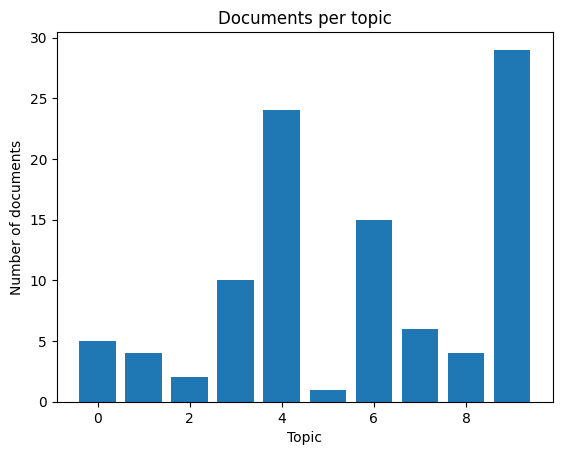

In [44]:
import matplotlib.pyplot as plt

topic_counts = np.bincount(dominant_topic)
plt.bar(range(len(topic_counts)), topic_counts)
plt.xlabel("Topic")
plt.ylabel("Number of documents")
plt.title("Documents per topic")
plt.show()


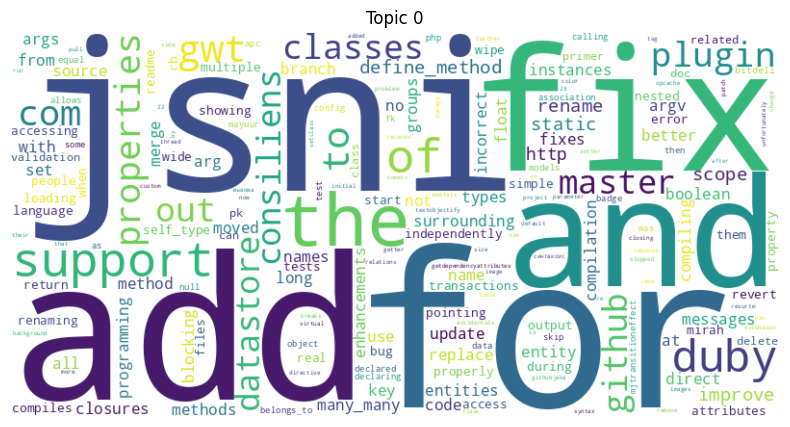

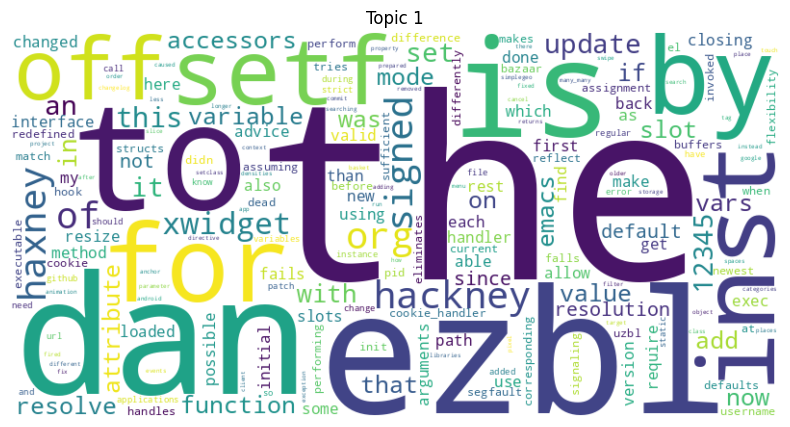

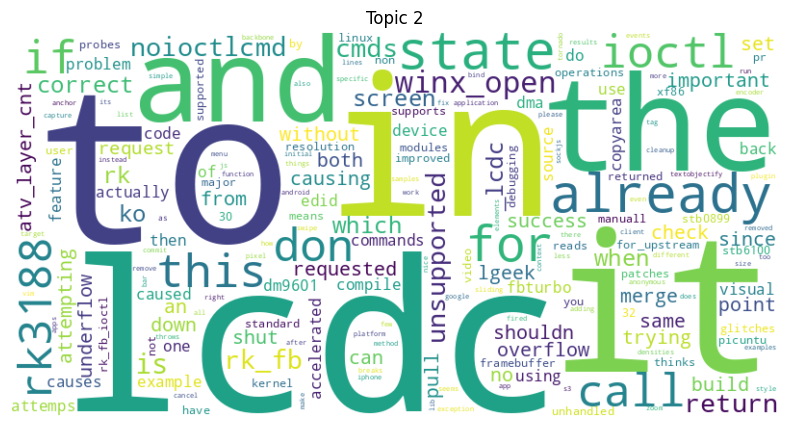

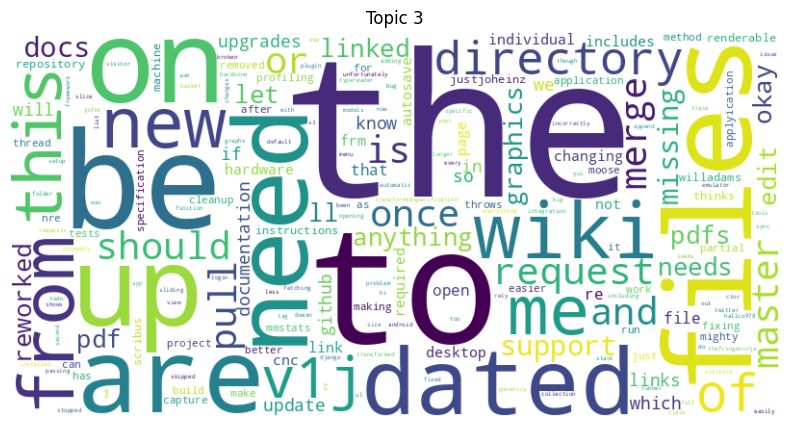

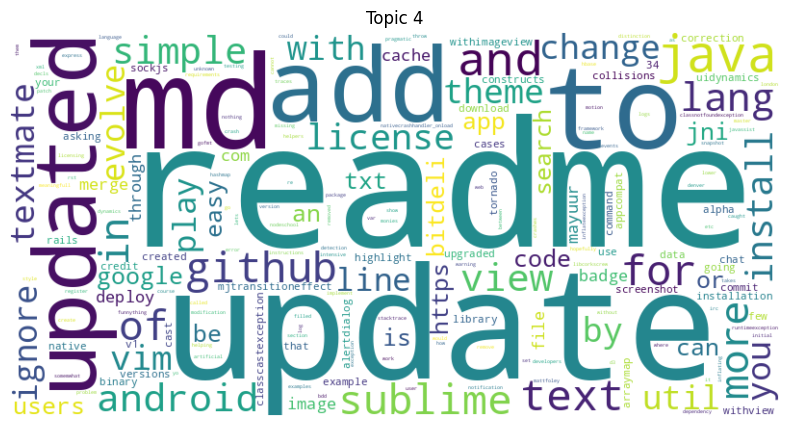

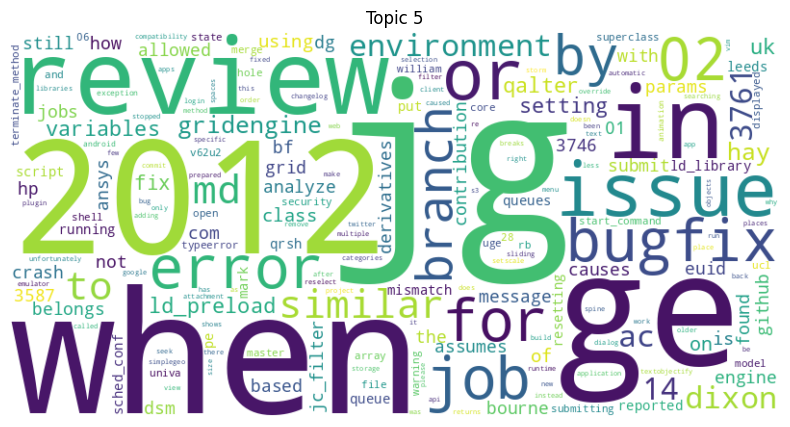

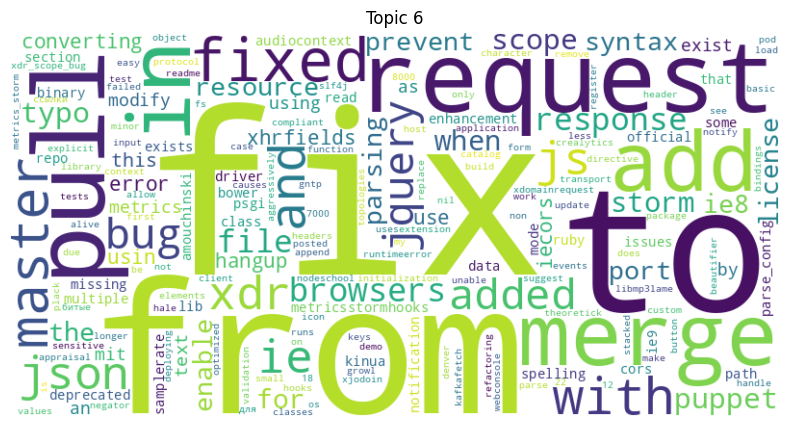

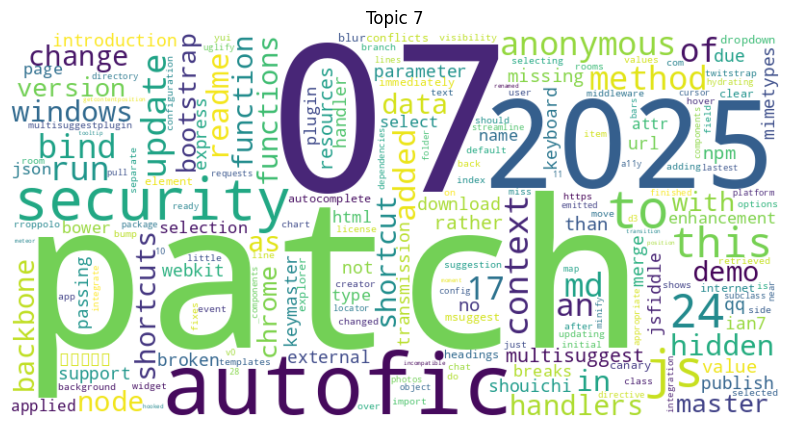

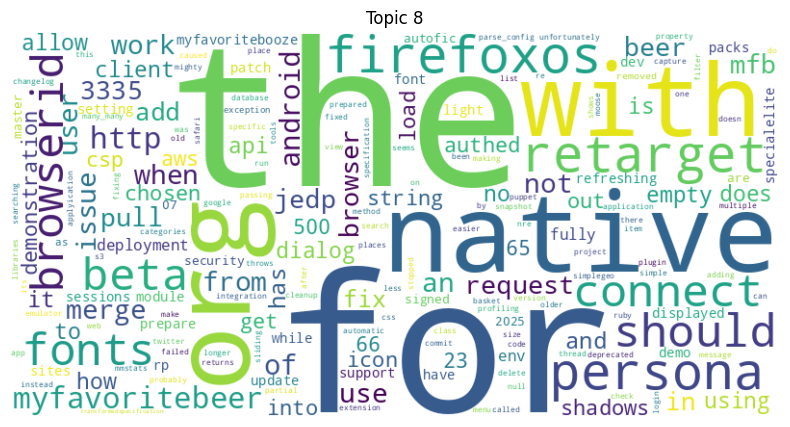

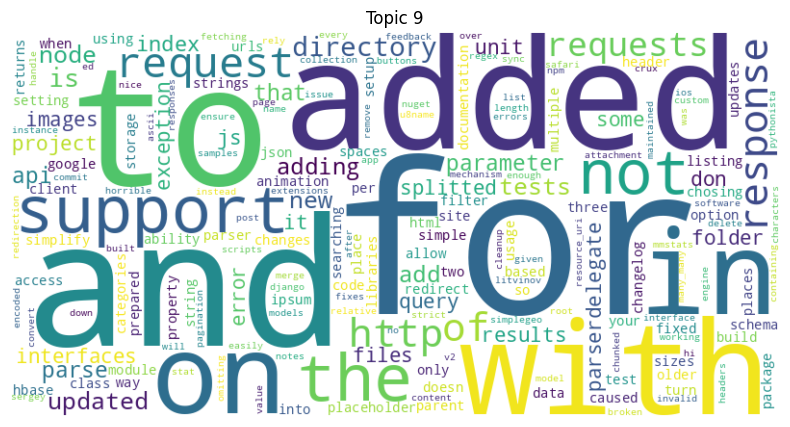

In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for topic_idx, topic in enumerate(nmf_model.components_):
    wc = WordCloud(width=800, height=400, background_color='white')
    freq_dict = {vocab[i]: topic[i] for i in range(len(vocab))}
    wc.generate_from_frequencies(freq_dict)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_idx}")
    plt.show()


In [39]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
import topicwizard as tw

# Fit CountVectorizer + NMF
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text_for_classification'])

nmf_model = NMF(n_components=10, random_state=42)
nmf_model.fit(X)

# Inférer les noms des topics
vocab = vectorizer.get_feature_names_out()
components = nmf_model.components_
topic_names = tw.infer_topic_names(vocab=vocab, components=components)

# Distrib des topics pour chaque doc
doc_topic_matrix = nmf_model.transform(X)

# Topic dominant
dominant_topic = np.argmax(doc_topic_matrix, axis=1)

# Créer topic_data correctement
topic_data = pd.DataFrame({
    'document': df['text_for_classification'],
    'topic': dominant_topic
})

topic_data['document_topic_matrix'] = list(doc_topic_matrix)  # chaque ligne = array

# IMPORTANT : TopicWizard attend une matrice 2D pour isnan(), donc il faut convertir la Series d’array en array 2D
topic_data_np = topic_data.copy()
topic_data_np['document_topic_matrix'] = np.array(topic_data['document_topic_matrix'].tolist())

# Visualiser
tw.visualize(
    topic_data=topic_data_np,
    topic_names=topic_names
)

Preprocessing


ValueError: No axis named 1 for object type Series

In [10]:
import re

def guess_category(text):
    text = str(text).lower()

    if re.search(r'\b(api|http|flask|django|express|fastapi|web)\b', text):
        return 'web'
    elif re.search(r'\b(plugin|extension|addon|theme|mod)\b', text):
        return 'plugin'
    elif re.search(r'\b(network|socket|vpn|dns|proxy|tcp|udp)\b', text):
        return 'network'
    elif re.search(r'\b(self[- ]?host|server|deployment|docker|container)\b', text):
        return 'selfhost'
    elif re.search(r'\b(kernel|driver|firmware|assembly|embedded|low[- ]?level|c\+\+|c\b)\b', text):
        return 'low_level'
    elif re.search(r'\b(machine learning|ml|deep learning|nlp|transformer|pytorch|tensorflow)\b', text):
        return 'ml_ai'
    elif re.search(r'\b(database|sql|mongo|postgres|orm|data)\b', text):
        return 'data'
    else:
        return 'other'
pip install topic-wizard

df['category'] = df['text_for_classification'].apply(guess_category)

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])

print(df[['category', 'label']].drop_duplicates().sort_values('label'))

df.head()

     category  label
44       data      0
25  low_level      1
0       other      2
17     plugin      3
12   selfhost      4
1         web      5


,full_name,html_url,description,language,stars,forks,open_issues,recent_commit_messages,recent_pr_titles,recent_issue_titles,top_contributors,text_for_classification,category,label
0,ahoward/testy,https://github.com/ahoward/testy,a BDD testing framework for ruby that's mad at...,Ruby,100,5,1,"Deal with more ""it's"". Replace ""it's"" with its...",NaN,Support for Ruby 2?,"ahoward, agrimm",a BDD testing framework for ruby that's mad at...,other,2
1,mauricio/master_slave_adapter,https://github.com/mauricio/master_slave_adapter,An ActiveRecord database adapter that allows y...,Ruby,100,22,1,Apply fixes suggested by http://github.com/dee...,NaN,change the name,mauricio,An ActiveRecord database adapter that allows y...,web,5
2,benaskins/simplegraph,https://github.com/benaskins/simplegraph,Simple graphs using jQuery and Raphael,JavaScript,100,11,2,"Stylistic changes, remove disclaimer. Missing ...",NaN,Error in README Bug when using lowerBound bigg...,"benaskins, lachlanhardy, martinstannard, lachie",Simple graphs using jQuery and Raphael Stylist...,other,2
3,headius/duby,https://github.com/headius/duby,The Duby Programming Language,Ruby,100,10,4,Wipe out source and replace with a README poin...,NaN,Direct access to ARGV Compiling multiple .duby...,"headius, consiliens, nex3, Osseta, bobzoller",The Duby Programming Language Wipe out source ...,web,5
4,masuidrive/TiStoreKit,https://github.com/masuidrive/TiStoreKit,StoreKit(In App Purchase) module for Titanium ...,JavaScript,100,20,1,Updated docs add removedTransactions. it was f...,NaN,question,masuidrive,StoreKit(In App Purchase) module for Titanium ...,other,2


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
import pandas as pd
import numpy as np

# === 1. Charger ton DataFrame ===
# ⚠️ il faut que df contienne une colonne texte (par ex. "description" ou concat de readme + commits + issues)
# et une colonne "label" qui contient les catégories numériques.
# Exemple:
# df['text_for_classification'] = df['description'] + " " + df['recent_commit_messages'] + " " + df['recent_issue_titles']
# df['label'] = label_encoder.fit_transform(df['category'])

# Exemple minimal :
# df = pd.read_csv("github_repos_full.csv").dropna(subset=["text_for_classification", "label"])

# === 2. Définir les catégories ===
categories = df['label'].unique().tolist()
num_labels = len(categories)
print(f"Nombre de classes : {num_labels}")

# === 3. Tokenizer / Model ===
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

# === 4. Préparation du dataset ===
class RepoDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.encodings = tokenizer(list(texts), padding=True, truncation=True, max_length=max_length)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === 5. Split train / test ===
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text_for_classification'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label'].values
)

train_dataset = RepoDataset(train_texts, train_labels, tokenizer)
val_dataset = RepoDataset(val_texts, val_labels, tokenizer)

# === 6. Entraînement ===
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("🚀 Début du fine-tuning...")
trainer.train()
print("✅ Entraînement terminé.")

# === 7. Évaluation ===
eval_results = trainer.evaluate()
print("\n📊 Résultats de validation :")
for k, v in eval_results.items():
    print(f"{k}: {v}")

# === 8. Sauvegarde du modèle ===
model.save_pretrained("./distilbert_github_classifier")
tokenizer.save_pretrained("./distilbert_github_classifier")

print("\n💾 Modèle et tokenizer sauvegardés dans ./distilbert_github_classifier")

# === 9. Prédiction exemple ===
sample_text = "Fast HTTP API server for deploying deep learning models with Docker"
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
pred_label = torch.argmax(outputs.logits, dim=1).item()

print(f"\n🔮 Catégorie prédite : {pred_label} ({categories[pred_label]})")
